In [1]:
import numpy as np  # for array stuff and random
from PIL import Image  # for creating visual of our env
import cv2  # for showing our visual live
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
import pickle  # to save/load Q-Tables
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.

style.use("ggplot")  # setting our style!

In [6]:
SIZE = 10

HM_EPISODES = 25000
MOVE_PENALTY = 1  # feel free to tinker with these!
ENEMY_PENALTY = 300  # feel free to tinker with these!
FOOD_REWARD = 25  # feel free to tinker with these!

epsilon = 0.9  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 1000  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95

PLAYER_N = 1  # player key in dict
FOOD_N = 2  # food key in dict
ENEMY_N = 3  # enemy key in dict

# the dict! Using just for colors
d = {1: (255, 175, 0),  # blueish color
     2: (0, 255, 0),  # green
     3: (0, 0, 255)}  # red

In [15]:

class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE-1:
            self.x = SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE-1:
            self.y = SIZE-1



In [16]:
start_q_table = None
if start_q_table is None:
    # initialize the q-table#
    q_table = {}
    for i in range(-SIZE+1, SIZE):
        for ii in range(-SIZE+1, SIZE):
            for iii in range(-SIZE+1, SIZE):
                    for iiii in range(-SIZE+1, SIZE):
                        q_table[((i, ii), (iii, iiii))] = [np.random.uniform(-5, 0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)



on #0, epsilon is 0.9
1000 ep mean: nan


C:\Anaconda\envs\ai_reinforcement_learning\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda\envs\ai_reinforcement_learning\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


on #1000, epsilon is 0.8143496042026991
1000 ep mean: -182.669
on #2000, epsilon is 0.736850308738993
1000 ep mean: -172.022
on #3000, epsilon is 0.6667263969758188
1000 ep mean: -160.366
on #4000, epsilon is 0.6032759749875001
1000 ep mean: -141.009
on #5000, epsilon is 0.5458639460622982
1000 ep mean: -122.509
on #6000, epsilon is 0.4939156538048405
1000 ep mean: -108.81
on #7000, epsilon is 0.4469111302061
1000 ep mean: -111.112
on #8000, epsilon is 0.4043798911079097
1000 ep mean: -94.307
on #9000, epsilon is 0.3658962269680627
1000 ep mean: -86.888
on #10000, epsilon is 0.3310749417896705
1000 ep mean: -77.964
on #11000, epsilon is 0.2995674975642777
1000 ep mean: -75.681
on #12000, epsilon is 0.2710585256371815
1000 ep mean: -72.87
on #13000, epsilon is 0.24526267007600694
1000 ep mean: -71.789
on #14000, epsilon is 0.22192173144677058
1000 ep mean: -54.684
on #15000, epsilon is 0.20080208240850625
1000 ep mean: -65.16
on #16000, epsilon is 0.18169232925827247
1000 ep mean: -56.0

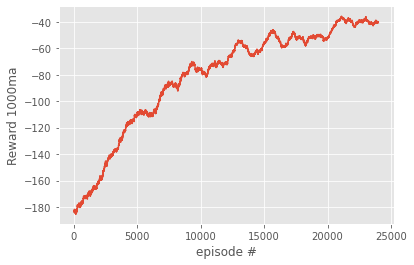

In [17]:

episode_rewards = []

for episode in range(HM_EPISODES):
    player = Blob()
    food = Blob()
    enemy = Blob()
    if episode % SHOW_EVERY == 0:
        print(f"on #{episode}, epsilon is {epsilon}")
        print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False

    episode_reward = 0
    for i in range(200):
        obs = (player-food, player-enemy)
        #print(obs)
        if np.random.random() > epsilon:
            # GET THE ACTION
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
        # Take the action!
        player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if player.x == enemy.x and player.y == enemy.y:
            reward = -ENEMY_PENALTY
        elif player.x == food.x and player.y == food.y:
            reward = FOOD_REWARD
        else:
            reward = -MOVE_PENALTY
        ## NOW WE KNOW THE REWARD, LET'S CALC YO
        # first we need to obs immediately after the move.
        new_obs = (player-food, player-enemy)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward == FOOD_REWARD:
            new_q = FOOD_REWARD
        else:
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[obs][action] = new_q

        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
            env[food.x][food.y] = d[FOOD_N]  # sets the food location tile to green color
            env[player.x][player.y] = d[PLAYER_N]  # sets the player tile to blue
            env[enemy.x][enemy.y] = d[ENEMY_N]  # sets the enemy location to red
            img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
            img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
            cv2.imshow("image", np.array(img))  # show it!
            if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:  # crummy code to hang at the end if we reach abrupt end for good reasons or not.
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        episode_reward += reward
        if reward == FOOD_REWARD or reward == -ENEMY_PENALTY:
            break

    #print(episode_reward)
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"Reward {SHOW_EVERY}ma")
plt.xlabel("episode #")
plt.show()

with open(f"qtable-{int(time.time())}.pickle", "wb") as f:
    pickle.dump(q_table, f)
